<a href="https://colab.research.google.com/github/ridoya09/Proyek-Analisis-Data/blob/main/Apriori/Engine_Apriori_LPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Representasi File analysis_engine.py

Kode di bawah ini akan disimpan dalam bentuk (.py),
pada sel 22dfe91b ada beberapa fungsi diantaranya sebagai berikut.
1. process_data_with_kmeans
2. find_association_rules
3. get_top_association_rules
4. filter_association_rules_by_keyword

In [47]:
import pandas as pd
import numpy as np
import warnings
import os
import re # Import regex module for word boundary matching
from sklearn.cluster import KMeans
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

# Suppress DeprecationWarning from jupyter_client - might still be useful depending on server environment
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn") # Suppress KMeans warnings


def process_data_with_kmeans(file_path_association, k_categorization=5):
    """
    Loads data from an Excel file, performs K-Means categorization on specified
    rate columns after outlier filtering, and returns the processed DataFrame
    with new category columns and cluster labels, along with cluster information.

    Args:
        file_path_association (str): The path to the input Excel file.
        k_categorization (int, optional): The number of clusters for K-Means.
                                           Defaults to 5.

    Returns:
        tuple: A tuple containing:
            - df_association (pd.DataFrame): The DataFrame with added LPO category
                                           and ClusterLabel columns. Returns an empty
                                           DataFrame if file loading or processing fails.
            - cluster_info (dict): A dictionary containing boundary and centroid
                                   information for each categorized column. Returns
                                   an empty dictionary if processing fails.
    """
    df_association = pd.DataFrame()
    cluster_info = {}

    # --- Step 1: Load the Excel file ---
    try:
        # Check if the file exists
        if not os.path.exists(file_path_association):
            print(f"Error: File not found at '{file_path_association}'")
            return df_association, cluster_info
        elif not file_path_association.lower().endswith('.xlsx'):
            print(f"Error: File is not an Excel file (.xlsx). Please provide a valid Excel file path.")
            return df_association, cluster_info
        else:
            df_association = pd.read_excel(file_path_association)
            print(f"Successfully loaded data from '{file_path_association}'")

    except Exception as e:
        print(f"An error occurred while loading the file: {e}")
        return df_association, cluster_info

    # --- Check if DataFrame was loaded successfully before proceeding ---
    if df_association.empty:
        return df_association, cluster_info # Return empty df and info if loading failed


    # --- Step 2: Categorization based on K-Means boundaries and Assign Cluster Labels ---
    target_columns_for_categorization = ['GAS RATE', 'OIL RATE', 'CONDENSATE RATE']

    # print("\n--- Calculating cluster boundaries for categorization ---") # Commented out
    for column in target_columns_for_categorization:
        # Initialize outlier bounds to None at the start of each loop iteration
        lower_bound_outlier = None
        upper_bound_outlier = None

        # print(f"Processing column for categorization: {column}") # Commented out
        if column not in df_association.columns:
             # print(f"Column '{column}' not found in df_association. Skipping boundary calculation.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_bound_outlier}
             # Add a placeholder cluster label column with NaN or -1 if column is missing
             df_association[f'{column}_ClusterLabel'] = np.nan
             continue

        # Handle potential NaN values in the column before calculating quartiles
        if df_association[column].dropna().empty:
             # print(f"Column '{column}' is empty or contains only NaN values. Skipping boundary calculation.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_bound_outlier}
             # Add a placeholder cluster label column with NaN
             df_association[f'{column}_ClusterLabel'] = np.nan
             continue

        # --- Outlier Filtering Bounds Calculation ---
        Q1_outlier = df_association[column].quantile(0.25)
        Q3_outlier = df_association[column].quantile(0.75)
        IQR_outlier = Q3_outlier - Q1_outlier
        lower_bound_outlier = Q1_outlier - 1.5 * IQR_outlier
        upper_bound_outlier = Q3_outlier + 1.5 * IQR_outlier
        # --- End Outlier Filtering Bounds Calculation ---


        # Use only non-outlier data for clustering
        df_non_outlier_col = df_association.loc[(df_association[column] >= lower_bound_outlier) & (df_association[column] <= upper_bound_outlier)].copy()
        df_non_outlier_col = df_non_outlier_col.dropna(subset=[column])


        # Check if there's enough data for clustering for this column
        if df_non_outlier_col.empty or k_categorization < 2 or len(np.unique(df_non_outlier_col[column].dropna())) < k_categorization:
             # print(f"Skipping clustering/boundary calculation for '{column}' due to insufficient non-outlier data ({len(df_non_outlier_col)}) or unique values ({len(np.unique(df_non_outlier_col[column].dropna()))}) for k={k_categorization}.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_bound_outlier}
             # Add a placeholder cluster label column with NaN for all rows in the original df
             df_association[f'{column}_ClusterLabel'] = np.nan
             continue


        # --- Apply KMeans Clustering ---
        X = df_non_outlier_col[[column]].values
        # Add check for number of samples vs clusters
        if len(X) < k_categorization:
             # print(f"Not enough data points ({len(X)}) for clustering '{column}' with k={k_categorization}. Skipping.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_bound_outlier}
             # Add a placeholder cluster label column with NaN for all rows in the original df
             df_association[f'{column}_ClusterLabel'] = np.nan
             continue


        kmeans = KMeans(n_clusters=k_categorization, random_state=42, n_init=10)
        # Ensure X is not empty before fitting KMeans
        if not df_non_outlier_col.empty:
             # Fit KMeans only to the non-outlier data
             kmeans.fit(X)
             centroids = kmeans.cluster_centers_
             # Sort centroids to ensure consistent boundary order
             sorted_centroid_indices = np.argsort(centroids.flatten())
             sorted_centroids = centroids[sorted_centroid_indices]

             cluster_boundaries = [(sorted_centroids[i][0] + sorted_centroids[i+1][0]) / 2 for i in range(len(sorted_centroids)-1)]

             cluster_info[column] = {
                 'boundaries': cluster_boundaries,
                 'min': df_non_outlier_col[column].min(),
                 'max': df_non_outlier_col[column].max(),
                 'lower_outlier_bound': lower_bound_outlier,
                 'upper_outlier_bound': upper_bound_outlier,
                 'sorted_centroids': sorted_centroids.flatten().tolist() # Store sorted centroids as well
             }

             # --- Assign Cluster Labels back to the original DataFrame ---
             # Predict cluster labels for the non-outlier data used for fitting
             labels_non_outlier = kmeans.predict(X)

             # Create a mapping from original cluster label to sorted centroid index (0 to k-1)
             # This ensures the labels are assigned in increasing order based on centroid values
             label_mapping = {original_label: sorted_label for sorted_label, original_label in enumerate(sorted_centroid_indices)}

             # Map the predicted labels to the sorted labels
             sorted_labels_non_outlier = np.vectorize(label_mapping.get)(labels_non_outlier)


             # Assign the sorted cluster labels back to the original df_association DataFrame
             # Initialize the new column with NaN
             df_association[f'{column}_ClusterLabel'] = np.nan
             # Use the index of the non-outlier DataFrame to assign labels correctly
             df_association.loc[df_non_outlier_col.index, f'{column}_ClusterLabel'] = sorted_labels_non_outlier

             # For outlier values (those outside the lower/upper bounds), assign a specific label if desired, e.g., -1 or np.nan
             # Current code leaves them as NaN, which is handled by dropna in plotting
             # If we want to assign a specific "Outlier" label, we could do:
             # df_association.loc[(df_association[column] < lower_outlier) | (df_association[column] > upper_outlier), f'{column}_ClusterLabel'] = -1 # Or a specific category string

        else:
             # print(f"DataFrame for '{column}' is empty after outlier filtering. Skipping clustering.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_bound_outlier': upper_bound_outlier}
             # Add a placeholder cluster label column with NaN for all rows in the original df
             df_association[f'{column}_ClusterLabel'] = np.nan


    # print("Categorization complete and Cluster Labels Assigned.") # Commented out

    def categorize_rate_final_logic(rate, column_name, cluster_info_dict, k_val):
        # This function assigns the string category names (LPO GAS_low etc.)
        if pd.isna(rate):
            base_col_name = column_name.replace(' RATE', '')
            return f'LPO {base_col_name}_Unknown' # Handle NaN values (still use Unknown for NaN)

        info = cluster_info_dict.get(column_name)

        # --- Modified Logic: Assign category based on boundaries for *any* non-NaN value if boundaries exist ---
        # If clustering was skipped or no boundaries were calculated, use a 'Skipped' label
        if info is None or not info['boundaries']:
             base_col_name = column_name.replace(' RATE', '')
             return f'LPO {base_col_name}_CategorizationSkipped' # Use 'CategorizationSkipped' instead of Unknown

        boundaries = info['boundaries']
        if k_val == 5: category_names_logic = ["very low", "low", "moderate", "high", "very high"]
        elif k_val == 4: category_names_logic = ["low", "moderate", "high", "very high"]
        elif k_val == 3: category_names_logic = ["low", "moderate", "high"]
        else: category_names_logic = [f"Category {i+1}" for i in range(k_val)]

        # Assign category based on boundaries for *any* non-NaN value
        base_col_name = column_name.replace(' RATE', '')

        # Check if rate is below the first boundary
        if rate < boundaries[0]:
            return f'LPO {base_col_name}_{category_names_logic[0]}'
        # Check if rate is between boundaries
        for i in range(len(boundaries) - 1):
            if boundaries[i] <= rate < boundaries[i+1]:
                return f'LPO {base_col_name}_{category_names_logic[i+1]}'
        # If rate is >= the last boundary, it falls into the last category
        return f'LPO {base_col_name}_{category_names_logic[-1]}'
        # --- End Modified Logic ---


    # Apply the categorization function to the target columns
    # Ensure target columns exist before applying categorization
    # The categorization now uses the modified logic which applies to all non-NaN values
    if 'GAS RATE' in df_association.columns:
        df_association['LPO GAS KATEGORI'] = df_association['GAS RATE'].apply(lambda x: categorize_rate_final_logic(x, 'GAS RATE', cluster_info, k_categorization))
    else:
         df_association['LPO GAS KATEGORI'] = 'LPO GAS_ColumnMissing' # Format placeholder with LPO prefix

    if 'OIL RATE' in df_association.columns:
        df_association['LPO OIL KATEGORI'] = df_association['OIL RATE'].apply(lambda x: categorize_rate_final_logic(x, 'OIL RATE', cluster_info, k_categorization))
    else:
         df_association['LPO OIL KATEGORI'] = 'LPO OIL_ColumnMissing' # Format placeholder with LPO prefix

    if 'CONDENSATE RATE' in df_association.columns:
        df_association['LPO COND KATEGORI'] = df_association['CONDENSATE RATE'].apply(lambda x: categorize_rate_final_logic(x, 'CONDENSATE RATE', cluster_info, k_categorization))
    else:
         df_association['LPO COND KATEGORI'] = 'LPO COND_ColumnMissing' # Format placeholder with LPO prefix


    # print("Categorization complete and Cluster Labels Assigned.") # Commented out

    # Return the processed DataFrame and cluster info
    return df_association, cluster_info


def find_association_rules(df, selected_columns, min_support=0.01, min_confidence=0.5, lift_threshold=1):
    """
    Prepares data for Apriori, applies the algorithm, and generates association rules.

    Args:
        df (pd.DataFrame): The input DataFrame (e.g., df_association).
        selected_columns (list): A list of column names to include in the analysis.
        min_support (float, optional): The minimum support threshold for Apriori.
                                        Defaults to 0.01.
        min_confidence (float, optional): The minimum confidence threshold for rules.
                                          Defaults to 0.5.
        lift_threshold (float, optional): The minimum lift threshold for rules.
                                          Defaults to 1.

    Returns:
        pd.DataFrame: The DataFrame of association rules. Returns an empty DataFrame
                      if the process fails or no rules are found.
    """
    rules = pd.DataFrame() # Initialize rules DataFrame


    if not selected_columns:
        print("No columns selected. Cannot proceed with association rule mining.")
        return rules # Return empty rules if no columns selected

    # --- Prepare Data for Apriori ---
    # Check if all selected columns exist in the DataFrame
    missing_columns = [col for col in selected_columns if col not in df.columns]
    if missing_columns:
        print(f"Error: The following selected columns were not found in the DataFrame: {missing_columns}")
        return rules # Return empty rules if columns are missing

    # Select the chosen columns.
    df_apriori_prep = df[selected_columns].copy()

    # Handle any missing values in the selected columns.
    initial_rows = df_apriori_prep.shape[0]
    df_apriori_prep = df_apriori_prep.dropna(subset=selected_columns) # Dropna based on selected columns
    rows_after_dropna = df_apriori_prep.shape[0]
    if initial_rows > rows_after_dropna:
        print(f"Dropped {initial_rows - rows_after_dropna} rows with missing values in selected columns.")


    # Filter out rows where LPO category columns are 'Unknown'
    # Apply this filter only if the category columns were selected
    category_cols_to_filter = ['LPO GAS KATEGORI', 'LPO OIL KATEGORI', 'LPO COND KATEGORI']
    selected_category_cols_to_filter = [col for col in selected_columns if col in category_cols_to_filter and col in df_apriori_prep.columns]

    filter_mask = pd.Series(False, index=df_apriori_prep.index) # Initialize with False

    for cat_col in selected_category_cols_to_filter:
         if cat_col in df_apriori_prep.columns:
              if pd.api.types.is_object_dtype(df_apriori_prep[cat_col]) or pd.api.types.is_string_dtype(df_apriori_prep[cat_col]):
                   # Filter out 'Unknown' categories from selected LPO columns
                   # Keep 'CategorizationSkipped' as requested
                   filter_mask = filter_mask | df_apriori_prep[cat_col].str.contains('_Unknown', na=False)


    rows_before_category_filter = df_apriori_prep.shape[0]
    df_apriori_prep = df_apriori_prep[~filter_mask].copy()
    rows_after_category_filter = df_apriori_prep.shape[0]

    if rows_before_category_filter > rows_after_category_filter:
         print(f"Dropped {rows_before_category_filter - rows_after_category_filter} rows with 'Unknown' categories in selected LPO columns.")


    if df_apriori_prep.empty:
         print("No data remaining after filtering out 'Unknown' categories. Cannot proceed with encoding.")
         return rules # Return empty rules if data is empty after filtering


    # Transform the filtered DataFrame into a list of lists (transactions).
    # Include all selected columns for encoding (both original and LPO categories)
    columns_for_encoding = [col for col in df_apriori_prep.columns if (pd.api.types.is_object_dtype(df_apriori_prep[col]) or pd.api.types.is_string_dtype(df_apriori_prep[col])) and col in df_apriori_prep.columns]

    # Add a check to ensure there are columns to encode
    if not columns_for_encoding:
        print("No valid columns for encoding found after filtering. Cannot perform Transaction Encoding.")
        return rules # Return empty rules if no columns to encode

    transactions = []
    # Use the values directly from df_apriori_prep
    for index, row in df_apriori_prep[columns_for_encoding].iterrows():
        transaction = [str(row[col]) for col in columns_for_encoding if pd.notna(row[col])]
        if transaction: # Only add non-empty transactions
             transactions.append(transaction)

    if not transactions:
         print("No valid transactions found after preparing for encoding. Cannot perform Transaction Encoding.")
         return rules # Return empty rules if no transactions

    # Instantiate TransactionEncoder.
    # Fit and transform.
    print("\nPreparing data using TransactionEncoder...")
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)

    # Convert to pandas DataFrame.
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # print("Transaction Encoding complete. Displaying head of encoded DataFrame:") # Commented out
    # display(df_encoded.head()) # Commented out
    print(f"Shape of encoded DataFrame: {df_encoded.shape}")


    # --- Apply Apriori Algorithm and Generate Rules ---
    # This block should only run if df_encoded was successfully created AND has valid boolean columns
    if df_encoded.shape[0] < 1 or df_encoded.shape[1] < 2: # Check for at least 2 columns/items for association
         print(f"\nDataFrame encoded is empty or has fewer than 2 columns ({df_encoded.shape[1]}) after preparation. Cannot apply Apriori.")
         return rules # Return empty rules if not enough data/columns
    elif not all(df_encoded.dtypes == bool):
        print("\nEncoded DataFrame contains non-boolean columns. Please check data preparation steps. Cannot apply Apriori.")
        print("Column dtypes:", df_encoded.dtypes)
        return rules # Return empty rules if dtypes are wrong
    else:
        print("\n--- Applying Apriori Algorithm and Generating Rules ---")
        # Apply the Apriori algorithm

        frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

        if not frequent_itemsets.empty:
            print("Frequent itemsets found. Generating association rules...")
            # Generate association rules
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

            # Filter rules by lift >= lift_threshold
            rules = rules[rules['lift'] >= lift_threshold]

            if rules.empty:
                 print(f"No association rules found with min_confidence={min_confidence} and lift>={lift_threshold}.")
            else:
                 print("Association rules generated.")


        else:
            print(f"Could not generate association rules because no frequent itemsets were found with the given minimum support ({min_support}).")
            # rules is already initialized as empty, no need to redefine

    # Return the generated rules DataFrame
    return rules

def get_top_association_rules(rules_df, top_n=10):
    """
    Sorts association rules based on consequent/antecedent category order,
    confidence, and lift, and returns the top N rules.

    Args:
        rules_df (pd.DataFrame): The input DataFrame of association rules.
        top_n (int, optional): The number of top rules to return. Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame containing the top N sorted association rules.
                      Returns an empty DataFrame if the input is empty or invalid.
    """
    if rules_df.empty:
        print("Input DataFrame of rules is empty. Cannot get top rules.")
        return pd.DataFrame() # Return empty DataFrame if input is empty

    # Ensure necessary columns exist
    required_cols = ['antecedents', 'consequents', 'confidence', 'lift']
    if not all(col in rules_df.columns for col in required_cols):
        print(f"Error: Input rules DataFrame is missing required columns: {list(set(required_cols) - set(rules_df.columns))}")
        return pd.DataFrame()


    # --- Custom Sorting Logic: Based on Category Order ---
    # Define the desired order of categories (from highest to lowest)
    category_order = ["very high", "high", "moderate", "low", "very low", "unknown", "categorizationskipped", "columnmissing"] # Include other potential categories and their order


    # Function to extract the category suffix from an item string
    def extract_category_suffix(item):
        item_lower = str(item).lower()
        # Check for LPO format first
        if item_lower.startswith('lpo '):
             parts = item_lower.split('_')
             if len(parts) > 1:
                  # The last part is the category name
                  return parts[-1]
        # Fallback or other non-LPO items - return a default or the whole item string
        return item_lower # Use the whole item if not in LPO format


    # Function to get a numerical score for sorting based on category order
    def get_category_sort_score(items, order):
        scores = []
        for item in items:
            category = extract_category_suffix(item)
            try:
                # Assign a score based on the inverse of the index (higher index = lower score)
                score = len(order) - order.index(category)
                scores.append(score)
            except ValueError:
                # Category not in the defined order, assign a low score
                scores.append(0) # Assign 0 for unknown categories

            # If no categorized items are found, return a score based on presence of *any* item
            if not scores:
                return 0 if not items else 1 # Assign a basic score if items exist but no known categories

            # Combine scores for multiple items in an itemset (e.g., sum or max)
            # Using max score to prioritize itemsets with higher categories
            return max(scores)


    # Apply the custom sorting score to antecedents and consequents
    # Work on a copy to avoid modifying the original rules_df outside the function if it was passed by reference
    rules_df_sorted = rules_df.copy()
    rules_df_sorted['antecedent_category_score'] = rules_df_sorted['antecedents'].apply(lambda x: get_category_sort_score(x, category_order))
    rules_df_sorted['consequent_category_score'] = rules_df_sorted['consequents'].apply(lambda x: get_category_sort_score(x, category_order))

    # Sort first by consequent category score (descending), then antecedent category score (descending),
    # then by confidence (descending), then lift (descending)
    sorted_rules_summary = rules_df_sorted.sort_values(
        by=['consequent_category_score', 'antecedent_category_score', 'confidence', 'lift'],
        ascending=[False, False, False, False]
    ).drop(['antecedent_category_score', 'consequent_category_score'], axis=1).copy() # Drop the temporary score columns and use .copy()


    # --- End Custom Sorting Logic ---

    # Return only the top N rules
    return sorted_rules_summary.head(top_n)


# Modified to accept a list of keywords and use 'AND' logic for filtering
def filter_association_rules_by_keyword(rules_df, keywords):
    """
    Filters association rules based on whether ALL provided keywords are present
    as exact items (case-insensitive) in either the antecedents or consequents frozensets.

    Args:
        rules_df (pd.DataFrame): The input DataFrame of association rules.
        keywords (str or list): A single keyword (str) or a list of keywords (list)
                                to filter by. Filtering is case-insensitive and
                                matches exact items within the frozensets.

    Returns:
        pd.DataFrame: A DataFrame containing the filtered association rules.
                      Returns an empty DataFrame if input is empty, keywords list is empty,
                      or no matching rules are found.
    """
    if rules_df.empty:
        return pd.DataFrame()

    # Convert single keyword string to a list for consistent processing
    if isinstance(keywords, str):
        keywords_list = [keywords]
    elif isinstance(keywords, list):
        keywords_list = keywords
    else:
        print("Error: Keywords input must be a string or a list of strings.")
        return pd.DataFrame()


    if not keywords_list:
        # print("No keywords provided. Returning all rules.") # Handled by caller
        return rules_df.copy() # Return a copy if no keywords


    # Convert all keywords to lowercase for case-insensitive comparison
    keywords_lower = [str(kw).lower() for kw in keywords_list]

    # Filter rules where ALL lowercase keywords are present as exact items
    # within the frozensets (converting items to lowercase for comparison)
    # Use 'all()' with a generator expression for the 'AND' logic
    filtered_rules = rules_df[
        rules_df['antecedents'].apply(lambda itemset: all(kw in {str(item).lower() for item in itemset} for kw in keywords_lower)) |
        rules_df['consequents'].apply(lambda itemset: all(kw in {str(item).lower() for item in itemset} for kw in keywords_lower))
    ].copy()

    return filtered_rules

# --- Example Usage (for testing within notebook) ---
# Assuming df_association and rules DataFrames are available from previous steps

# # Example 1: Process data and find rules
# file_path = "/content/drive/MyDrive/Proyekan Mas Ivan/SF Jan-Aug 2025.xlsx"
# k_value = 5
# selected_columns_for_apriori = ['EVENTNAME', 'EVENTDAYWELLNAME', 'LPO GAS KATEGORI', 'LPO OIL KATEGORI', 'LPO COND KATEGORI']
# min_support_value = 0.01
# min_confidence_value = 0.5
# lift_threshold_value = 1

# df_association_processed, cluster_info_result = process_data_with_kmeans(file_path, k_value)

# if not df_association_processed.empty:
#      rules_result = find_association_rules(df_association_processed, selected_columns_for_apriori, min_support_value, min_confidence_value, lift_threshold_value)

#      # Example 2: Get top rules
#      if not rules_result.empty:
#          top_rules_display = 10
#          print(f"\n--- Top {top_rules_display} Association Rules ---")
#          pd.options.display.float_format = '{:,.4f}'.format
#          display(get_top_association_rules(rules_result, top_rules_display))

#          # Example 3: Filter rules by keyword
#          # Modified example to use a list of keywords
#          filter_keywords_input = input("Enter keyword(s) to filter rules (comma-separated for AND logic): ")
#          # Split the input string by comma and strip whitespace to get a list of keywords
#          filter_keywords_list = [kw.strip() for kw in filter_keywords_input.split(',') if kw.strip()] if filter_keywords_input else []

#          print(f"\n--- Association Rules Filtered by Keyword(s): '{', '.join(filter_keywords_list)}' ---")

#          filtered_rules_df = filter_association_rules_by_keyword(rules_result, filter_keywords_list)

#          if not filtered_rules_df.empty:
#              pd.options.display.float_format = '{:,.4f}'.format
#              display(filtered_rules_df)
#              print(f"\nFound {len(filtered_rules_df)} matching association rules.")
#          else:
#              if filter_keywords_list:
#                  print(f"No association rules found containing all keywords: {', '.join(filter_keywords_list)}.")
#              else:
#                   print("No association rules found in the input DataFrame.")

#      else:
#          print("\nNo rules generated to get top rules or filter.")
# else:
#      print("\nData processing failed. Cannot find rules, get top rules, or filter rules.")

###  Pemrosesan Data dan Kategorisasi K-Means

Bagian kode ini (khususnya pada sel yang memanggil fungsi `process_data_with_kmeans`) bertujuan untuk:

1.  **Memuat Data**: Membaca data dari file Excel yang ditentukan.
2.  **Validasi Data Input**: Kode ini mengasumsikan bahwa file Excel input **sudah memiliki kolom-kolom berikut:**
    *   `GAS RATE`
    *   `OIL RATE`
    *   `CONDENSATE RATE`

    Jika kolom-kolom ini belum ada, mereka perlu dihitung terlebih dahulu dari data mentah (misalnya, dengan membagi kolom loss seperti `EVENTDAYLOSSGAS` dengan `EVENTDAYDOWNTIME`). Langkah perhitungan ini **tidak** dilakukan dalam fungsi `process_data_with_kmeans` saat ini.

3.  **Pemfilteran Outlier**: Melakukan identifikasi dan pemfilteran data outlier pada kolom `GAS RATE`, `OIL RATE`, dan `CONDENSATE RATE` menggunakan metode IQR (Interquartile Range).
4.  **Kategorisasi K-Means**: Menerapkan algoritma K-Means clustering pada data non-outlier dari kolom `GAS RATE`, `OIL RATE`, dan `CONDENSATE RATE` untuk mengelompokkan nilai-nilai ke dalam `k` kategori (jumlah klaster ditentukan). Kategori ini diberi nama seperti "very low", "low", "moderate", "high", "very high" berdasarkan rentang nilai klaster.
5.  **Penambahan Kolom Baru**: Menambahkan kolom-kolom baru ke DataFrame asli:
    *   `LPO GAS KATEGORI`, `LPO OIL KATEGORI`, `LPO COND KATEGORI`: Berisi nama kategori string (misalnya, 'LPO GAS_moderate') berdasarkan hasil K-Means.
    *   `GAS RATE_ClusterLabel`, `OIL RATE_ClusterLabel`, `CONDENSATE RATE_ClusterLabel`: Berisi label numerik klaster (0, 1, 2, ...) yang ditetapkan oleh K-Means.
6.  **Menghasilkan Informasi Klaster**: Mengembalikan dictionary `cluster_info` yang berisi detail tentang klaster yang terbentuk, termasuk batas-batas nilai untuk setiap kategori yang digunakan dalam penamaan kategori string.

**Output utama dari bagian ini adalah DataFrame yang diperkaya dengan kolom kategori dan label klaster, serta informasi detail mengenai rentang nilai untuk setiap kategori K-Means.** Data ini kemudian siap untuk digunakan dalam analisis aturan asosiasi dan visualisasi distribusi data berdasarkan klaster.

###  Pemrosesan Data dan Kategorisasi K-Means

Bagian kode ini (khususnya pada sel yang memanggil fungsi `process_data_with_kmeans`) bertujuan untuk:

1.  **Memuat Data**: Membaca data dari file Excel yang ditentukan. **PENTING:** File Excel input **HARUS mencakup kolom-kolom berikut:**
    *   `GAS RATE`
    *   `OIL RATE`
    *   `CONDENSATE RATE`

    Pengembang web perlu memastikan bahwa data yang diunggah atau diakses oleh aplikasi memiliki kolom-kolom ini. Idealnya, struktur database sumber juga disesuaikan untuk menyediakan kolom-kolom laju produksi (`GAS RATE`, `OIL RATE`, `CONDENSATE RATE`) ini secara langsung, karena langkah perhitungan dari kolom loss (**seperti membagi `EVENTDAYLOSSGAS` dengan `EVENTDAYDOWNTIME`**) **tidak** dilakukan dalam fungsi `process_data_with_kmeans` saat ini.

2.  **Validasi Data Input**: Kode ini mengasumsikan bahwa file Excel input **sudah memiliki kolom-kolom berikut:**
    *   `GAS RATE`
    *   `OIL RATE`
    *   `CONDENSATE RATE`

    Jika kolom-kolom ini belum ada, mereka perlu dihitung terlebih dahulu dari data mentah (misalnya, dengan membagi kolom loss seperti `EVENTDAYLOSSGAS` dengan `EVENTDAYDOWNTIME`). Langkah perhitungan ini **tidak** dilakukan dalam fungsi `process_data_with_kmeans` saat ini.

3.  **Pemfilteran Outlier**: Melakukan identifikasi dan pemfilteran data outlier pada kolom `GAS RATE`, `OIL RATE`, dan `CONDENSATE RATE` menggunakan metode IQR (Interquartile Range).
4.  **Kategorisasi K-Means**: Menerapkan algoritma K-Means clustering pada data non-outlier dari kolom `GAS RATE`, `OIL RATE`, dan `CONDENSATE RATE` untuk mengelompokkan nilai-nilai ke dalam `k` kategori (jumlah klaster ditentukan). Kategori ini diberi nama seperti "very low", "low", "moderate", "high", "very high" berdasarkan rentang nilai klaster.
5.  **Penambahan Kolom Baru**: Menambahkan kolom-kolom baru ke DataFrame asli:
    *   `LPO GAS KATEGORI`, `LPO OIL KATEGORI`, `LPO COND KATEGORI`: Berisi nama kategori string (misalnya, 'LPO GAS_moderate') berdasarkan hasil K-Means.
    *   `GAS RATE_ClusterLabel`, `OIL RATE_ClusterLabel`, `CONDENSATE RATE_ClusterLabel`: Berisi label numerik klaster (0, 1, 2, ...) yang ditetapkan oleh K-Means.
6.  **Menghasilkan Informasi Klaster**: Mengembalikan dictionary `cluster_info` yang berisi detail tentang klaster yang terbentuk, termasuk batas-batas nilai untuk setiap kategori yang digunakan dalam penamaan kategori string.

**Output utama dari bagian ini adalah DataFrame yang diperkaya dengan kolom kategori dan label klaster, serta informasi detail mengenai rentang nilai untuk setiap kategori K-Means.** Data ini kemudian siap untuk digunakan dalam analisis aturan asosiasi dan visualisasi distribusi data berdasarkan klaster.

In [55]:
# --- Cell 1: Call to process_data_with_kmeans Function ---

# Ensure the function process_data_with_kmeans is defined (e.g., by running cell 22dfe91b)
if 'process_data_with_kmeans' not in globals():
    print("Error: Function 'process_data_with_kmeans' not found. Please run the cell containing the function definitions first.")
    df_association = pd.DataFrame() # Initialize to prevent errors
    cluster_info = {} # Initialize to prevent errors
else:
    # Define the file path and k value here before calling the function
    file_path = "/content/drive/MyDrive/Proyekan Mas Ivan/Shortfall2.xlsx"
    # Assuming k is available from cell OjdosFsFr7kn. If not, set a default.
    if 'k' not in globals():
        # print("Variable 'k' not found, using default k=5 for categorization.") # Commented out
        k_value = 5
    else:
        k_value = globals()['k']

    # Call the function and assign the returned values to variables
    df_association, cluster_info = process_data_with_kmeans(file_path, k_value)

    # Optional: Display head of the processed DataFrame after the function call
    if not df_association.empty:
        print("\nDataFrame 'df_association' after processing and categorization:")
        # Display relevant columns including the new LPO categories and cluster labels
        display(df_association[['GAS RATE', 'OIL RATE', 'CONDENSATE RATE',
                                'LPO GAS KATEGORI', 'LPO OIL KATEGORI', 'LPO COND KATEGORI',
                                'GAS RATE_ClusterLabel', 'OIL RATE_ClusterLabel', 'CONDENSATE RATE_ClusterLabel']].head())

    # Optional: Generate and display the formatted cluster ranges string after the function call
    if cluster_info:
        formatted_output_lines = ["Rentang Nilai Berdasarkan Batas Klaster:"]

        # Ensure k_value is available
        # k_value is defined above, no need to check globals/locals again

        # Define category names based on k_value
        if k_value == 5:
            category_names_display = ["very low", "low", "moderate", "high", "very high"]
        elif k_value == 4:
             category_names_display = ["low", "moderate", "high", "very high"]
        elif k_value == 3:
             category_names_display = ["low", "moderate", "high"]
        else:
             category_names_display = [f"Category {i+1}" for i in range(k_value)] # Generic names


        for col_name_long, info in cluster_info.items(): # Iterate through cluster_info
            col_name_short = col_name_long.replace(' RATE', '').replace('LPO ', '').replace(' KATEGORI', '')
            formatted_output_lines.append(f"\n--- {col_name_long} ---") # Display full column name

            boundaries = info.get('boundaries', [])
            min_val = info.get('min')
            max_val = info.get('max')
            lower_outlier_display = info.get('lower_outlier_bound') # Use a different variable name for clarity
            upper_outlier_display = info.get('upper_outlier_bound') # Use a different variable name for clarity


            if not boundaries:
                 formatted_output_lines.append("  Kategorisasi dilewati karena data tidak mencukupi atau k tidak sesuai.")
                 if lower_outlier_display is not None and upper_outlier_display is not None:
                      formatted_output_lines.append(f"  Rentang data non-outlier: >= {lower_outlier_display:.4f} dan <= {upper_outlier_display:.4f}")
                 elif min_val is not None and max_val is not None:
                      formatted_output_lines.append(f"  Rentang data: >= {min_val:.4f} dan <= {max_val:.4f}")

            else:
                # Ensure the number of category names matches the number of expected ranges (boundaries + 1)
                if len(category_names_display) != len(boundaries) + 1:
                     # Handle mismatch - maybe log a warning or add a specific row
                     formatted_output_lines.append(f"  Warning: Number of category names ({len(category_names_display)}) does not match expected ranges ({len(boundaries) + 1}). Raw boundaries: {boundaries}")
                     # formatted_output_lines.append(f"  Boundaries: {boundaries}") # Can include raw boundaries as well
                     # Add other info if needed for debugging
                     if min_val is not None: formatted_output_lines.append(f"  Min (non-outlier): {min_val:.4f}")
                     if max_val is not None: formatted_output_lines.append(f"  Max (non-outlier): {max_val:.4f}")
                     if lower_outlier_display is not None: formatted_output_lines.append(f"  Lower Outlier Bound: {lower_outlier_display:.4f})")
                     if upper_outlier_display is not None: formatted_output_lines.append(f"  Upper Outlier Bound: {upper_outlier_display:.4f})")


                else:
                    # Format the ranges using the category names
                    formatted_output_lines.append(f"  {category_names_display[0]}: < {boundaries[0]:.4f}")
                    for i in range(len(boundaries) - 1):
                        formatted_output_lines.append(f"  {category_names_display[i+1]}: {boundaries[i]:.4f} <= value < {boundaries[i+1]:.4f}")
                    # Fix: Use category_names_display here
                    formatted_output_lines.append(f"  {category_names_display[-1]}: >= {boundaries[-1]:.4f}")

        kmeans_ranges_output = "\n".join(formatted_output_lines)
        print("\nK-Means Cluster Ranges:")
        print(kmeans_ranges_output)

# Note: df_association and cluster_info are now available in the global scope after the function call

Successfully loaded data from '/content/drive/MyDrive/Proyekan Mas Ivan/Shortfall2.xlsx'

DataFrame 'df_association' after processing and categorization:


,GAS RATE,OIL RATE,CONDENSATE RATE,LPO GAS KATEGORI,LPO OIL KATEGORI,LPO COND KATEGORI,GAS RATE_ClusterLabel,OIL RATE_ClusterLabel,CONDENSATE RATE_ClusterLabel
0,0.0000,0,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low,0.0000,NaN,0.0000
1,0.0000,0,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low,0.0000,NaN,0.0000
2,0.0000,0,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low,0.0000,NaN,0.0000
3,0.0000,0,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low,0.0000,NaN,0.0000
4,0.0000,0,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low,0.0000,NaN,0.0000



K-Means Cluster Ranges:
Rentang Nilai Berdasarkan Batas Klaster:

--- GAS RATE ---
  very low: < 0.0922
  low: 0.0922 <= value < 0.2641
  moderate: 0.2641 <= value < 0.5054
  high: 0.5054 <= value < 0.8420
  very high: >= 0.8420

--- OIL RATE ---
  Kategorisasi dilewati karena data tidak mencukupi atau k tidak sesuai.
  Rentang data non-outlier: >= 0.0000 dan <= 0.0000

--- CONDENSATE RATE ---
  very low: < 0.9112
  low: 0.9112 <= value < 3.0629
  moderate: 3.0629 <= value < 5.6675
  high: 5.6675 <= value < 8.1794
  very high: >= 8.1794


Setelah mendapatkan batasan kategori

### Penjelasan untuk Web Developer: Visualisasi Distribusi Data Berdasarkan Klaster K-Means (Sel `3v4WM7kcQO_r`)

Sel kode ini bertujuan untuk memvisualisasikan hasil dari proses kategorisasi K-Means yang dilakukan pada tahap sebelumnya (Sel `Fv4cSLsW22aR`). Tujuannya adalah untuk membantu memahami bagaimana data pada kolom-kolom laju produksi (`GAS RATE`, `OIL RATE`, `CONDENSATE RATE`) terdistribusi dalam setiap klaster yang dibentuk oleh algoritma K-Means.

Berikut rinciannya:

1.  **Mengambil Data dan Informasi Klaster**: Kode ini menggunakan DataFrame `df_association` dan dictionary `cluster_info` yang dihasilkan dari sel `Fv4cSLsW22aR`. DataFrame ini sudah berisi kolom-kolom laju produksi asli dan kolom label klaster K-Means (`_ClusterLabel`).
2.  **Membuat Histogram**: Untuk setiap kolom laju produksi (`GAS RATE`, `OIL RATE`, `CONDENSATE RATE`) yang berhasil dikategorikan oleh K-Means, kode ini membuat histogram.
3.  **Pewarnaan Berdasarkan Klaster**: Histogram diwarnai sedemikian rupa sehingga setiap warna mewakili satu klaster K-Means. Ini memungkinkan visualisasi seberapa banyak data dari setiap klaster berada dalam rentang nilai tertentu.
4.  **Penanganan Kolom yang Dilewati**: Jika suatu kolom (seperti 'CONDENSATE RATE' dalam contoh output) tidak memiliki data yang cukup atau tidak memenuhi syarat untuk clustering K-Means, histogram dasar akan dibuat tanpa pewarnaan klaster.
5.  **Output Visual**: Hasilnya adalah satu atau lebih grafik histogram (satu per kolom laju produksi) yang menampilkan distribusi data, dengan warna yang menunjukkan keanggotaan klaster.

**Tujuan dari visualisasi ini adalah untuk memberikan gambaran visual tentang sebaran nilai dalam setiap klaster K-Means, memvalidasi hasil clustering, dan membantu interpretasi karakteristik data di setiap kategori (very low, low, dll.) yang ditentukan oleh K-Means.** Bagi pengembang web, output visual ini adalah elemen penting yang perlu ditampilkan di antarmuka pengguna untuk menunjukkan hasil analisis K-Means.

Generating Histograms colored by K-Means Cluster Label (where possible):
  Histogram for 'GAS RATE' colored by Cluster Indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
K-Means clustering did not yield enough valid clusters for 'OIL RATE'. Plotting basic histogram.
  Histogram for 'CONDENSATE RATE' colored by Cluster Indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


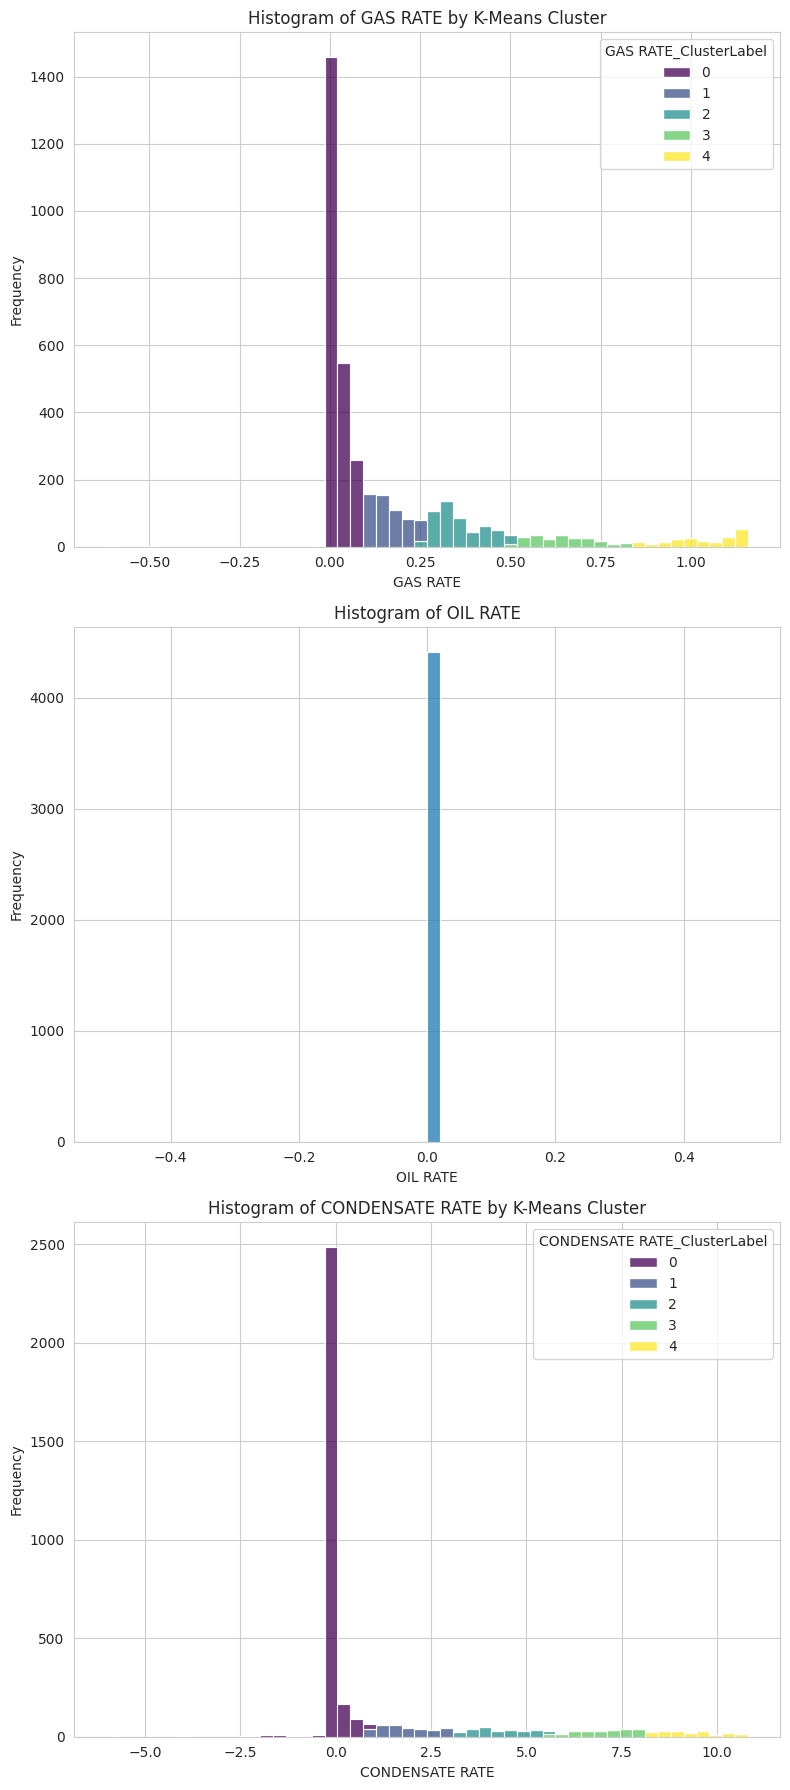

In [56]:
# --- Verification Cell: Histogram of K-Means Results (Colored by Cluster or Basic, Uniform Appearance) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy for plotting logic

# Ensure df_association and cluster_info exist from the previous cell
if ('df_association' in locals() or 'df_association' in globals()) and \
   ('cluster_info' in locals() or 'cluster_info' in globals()):

    df = globals().get('df_association')
    cluster_info = globals().get('cluster_info')
    target_columns = ['GAS RATE', 'OIL RATE', 'CONDENSATE RATE'] # Original columns used for categorization

    print("Generating Histograms colored by K-Means Cluster Label (where possible):")

    # Determine the number of plots needed (plot all target columns if they exist)
    columns_to_plot = [col for col in target_columns if col in df.columns]

    if not columns_to_plot:
        print("None of the target columns ('GAS RATE', 'OIL RATE', 'CONDENSATE RATE') found in df_association. Cannot generate histograms.")
    else:
        num_plots = len(columns_to_plot)
        # Adjust layout based on number of plots - Vertical layout
        fig, axes = plt.subplots(num_plots, 1, figsize=(8, 6 * num_plots)) # 8 wide, 6*num_plots tall


        # Ensure axes is an array even for a single subplot
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])

        # Set a consistent number of bins for all histograms
        consistent_bins = 50 # You can adjust this number


        # Apply a Seaborn style for better aesthetics
        sns.set_style("whitegrid") # Or "ticks", "darkgrid", "white"


        for i, column in enumerate(columns_to_plot):
            ax = axes[i] # Get the correct subplot axis
            label_col = f'{column}_ClusterLabel' # Get the name of the cluster label column

            # Check if cluster labels are available and meaningful for this column
            plot_colored_histogram = False
            df_plot_colored = pd.DataFrame() # Initialize empty DataFrame for colored plot
            unique_labels = [] # Initialize unique labels list

            if label_col in df.columns:
                 # Filter out rows where the label is NaN for colored plotting
                 # Also drop NaNs from the data column itself
                 df_plot_colored = df.dropna(subset=[column, label_col]).copy()

                 if not df_plot_colored.empty:
                      # Convert labels to integer type for plotting
                      # Handle potential float conversion issues from NaN
                      df_plot_colored[label_col] = df_plot_colored[label_col].astype(int)
                      unique_labels = sorted(df_plot_colored[label_col].unique())
                      # Exclude -1 if it's used for outliers
                      unique_labels = [lbl for lbl in unique_labels if lbl >= 0] # Assuming labels are 0, 1, ..., k-1

                      # Check if there are enough unique, non-negative labels for hue plotting
                      if len(unique_labels) > 1:
                          plot_colored_histogram = True
                          hue_order = unique_labels # Use the valid unique labels for order


            if plot_colored_histogram:
                 # Print which cluster indices are being plotted in color
                 print(f"  Histogram for '{column}' colored by Cluster Indices: {unique_labels}")

                 # Plot histogram colored by cluster label with consistent bins
                 sns.histplot(data=df_plot_colored, x=column, hue=label_col, multiple="stack", kde=False, ax=ax, hue_order=hue_order, palette="viridis", bins=consistent_bins) # Use multiple="stack" for stacked bars, kde=False, added bins
                 ax.set_title(f'Histogram of {column} by K-Means Cluster')
                 ax.set_xlabel(column)
                 ax.set_ylabel('Frequency')

                 # --- Corrected Legend Generation ---
                 # Get handles and labels from the plot artists
                 handles, labels = ax.get_legend_handles_labels()
                 # Ensure handles were generated before trying to create legend
                 if handles:
                      # Ensure the number of labels matches the number of handles, use unique_labels as labels
                      if len(handles) == len(unique_labels):
                           ax.legend(handles=handles, labels=unique_labels, title="Cluster Index")
                      else:
                           # Fallback if number of handles doesn't match unique_labels (unexpected)
                           ax.legend(title="Cluster Index (Labels Mismatch)")
                           print(f"  Warning: Number of legend handles ({len(handles)}) does not match unique cluster labels ({len(unique_labels)}) for '{column}'. Legend might be incorrect.")

                 # --- End Corrected Legend Generation ---


            else:
                 # Fallback to plotting a simple histogram of the original data if colored plot is not possible
                 print(f"K-Means clustering did not yield enough valid clusters for '{column}'. Plotting basic histogram.")
                 # Use the original column data, dropping NaNs only for the plotting column, with consistent bins and no kde
                 sns.histplot(df[column].dropna(), kde=False, ax=ax, bins=consistent_bins) # Plot basic histogram with kde=False, added bins
                 ax.set_title(f'Histogram of {column}')
                 ax.set_xlabel(column)
                 ax.set_ylabel('Frequency')

                 # Removed the code that adds vertical boundary lines

            # Ensure y-axis starts at 0 for better comparison
            ax.set_ylim(bottom=0)


        plt.tight_layout()
        plt.show()

else:
    # Check which variable is missing for a more specific error message
    if 'df_association' not in locals() and 'df_association' not in globals():
         print("DataFrame 'df_association' not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully.")
    elif 'cluster_info' not in locals() and 'cluster_info' not in globals():
         print("Dictionary 'cluster_info' not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully.")
    else:
        print("Required variables ('df_association', 'cluster_info') not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully.")

In [57]:
# --- Verification Cell: Display df_association after Categorization ---

from IPython.display import display

# Check if df_association exists from the previous cell
if 'df_association' in locals() or 'df_association' in globals():
    print("Displaying head of df_association after K-Means Categorization:")
    display(df_association)
else:
    print("DataFrame 'df_association' not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully.")

Displaying head of df_association after K-Means Categorization:


,EVENTDAYWELLNAME,start_time,end_time,EVENTNAME,EVENTDAYDOWNTIME,EVENTDAYLOSSGAS,EVENTDAYLOSSOIL,EVENTDAYLOSSCONDENSATEFORMATION,GAS RATE,OIL RATE,CONDENSATE RATE,SIBU/NonSIBU,ROOTCAUSEDESCRIPTION,GAS RATE_ClusterLabel,OIL RATE_ClusterLabel,CONDENSATE RATE_ClusterLabel,LPO GAS KATEGORI,LPO OIL KATEGORI,LPO COND KATEGORI
0,PK-A10:S1,2004-02-15,2004-02-16,NaN,24.0000,0.0000,0,0.0000,0.0000,0,0.0000,NonSIBU,EOD Event,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low
1,PK-A1:S1,2004-02-15,2004-02-16,NaN,24.0000,0.0000,0,0.0000,0.0000,0,0.0000,NonSIBU,EOD Event,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low
2,PK-A11-ST1:S1,2004-02-15,2004-02-16,NaN,24.0000,0.0000,0,0.0000,0.0000,0,0.0000,NonSIBU,EOD Event,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low
3,PK-A1:S1,2004-02-16,2004-02-17,NaN,24.0000,0.0000,0,0.0000,0.0000,0,0.0000,NonSIBU,EOD Event,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low
4,PK-A11-ST1:S1,2004-02-16,2004-02-17,NaN,24.0000,0.0000,0,0.0000,0.0000,0,0.0000,NonSIBU,EOD Event,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4408,PK-A19-rSH1:S1,2025-08-02,2025-08-03,WRNP_WDI,24.0000,0.5000,0,0.0000,0.0208,0,0.0000,SIBU,SIBU,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low
4409,PK-A19-rSH1:S1,2025-08-03,2025-08-04,WRNP_WDI,24.0000,0.5000,0,0.0000,0.0208,0,0.0000,SIBU,SIBU,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low
4410,PK-A19-rSH1:S1,2025-08-04,2025-08-05,WRNP_WDI,24.0000,0.5000,0,0.0000,0.0208,0,0.0000,SIBU,SIBU,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low
4411,PK-A19-rSH1:S1,2025-08-05,2025-08-06,WRNP_WDI,24.0000,0.5000,0,0.0000,0.0208,0,0.0000,SIBU,SIBU,0.0000,NaN,0.0000,LPO GAS_very low,LPO OIL_CategorizationSkipped,LPO CONDENSATE_very low


### Penjelasan untuk Web Developer: Menemukan Aturan Asosiasi (Sel `-upNqgRvkzhz`)

Sel kode ini bertujuan untuk menerapkan algoritma Apriori dan menghasilkan aturan asosiasi dari data yang telah diproses pada tahap sebelumnya (khususnya DataFrame `df_association` dari Sel `Fv4cSLsW22aR`). Tujuannya adalah untuk mengidentifikasi pola atau hubungan menarik antara berbagai "item" dalam data, seperti kombinasi kategori laju produksi, nama sumur, atau jenis event.

Berikut rinciannya:

1.  **Menggunakan Data yang Diproses**: Kode ini mengambil DataFrame `df_association` yang sudah ditambahkan kolom kategori K-Means (`LPO GAS KATEGORI`, dll.) dan label klaster.
2.  **Memilih Kolom untuk Analisis**: Di awal sel, ada variabel `selected_columns_for_apriori` yang menentukan kolom-kolom mana dari DataFrame yang akan dimasukkan ke dalam analisis aturan asosiasi. Kolom-kolom ini biasanya adalah kolom kategorikal atau kolom yang telah dikategorikan (seperti kategori LPO). **Pengembang web mungkin perlu menyediakan antarmuka agar pengguna dapat memilih kolom-kolom ini.**
3.  **Menyiapkan Data untuk Apriori**: Data dari kolom-kolom yang dipilih diubah menjadi format "transaksi" yang dapat diproses oleh algoritma Apriori. Ini melibatkan penanganan nilai yang hilang (NaN) dan kategori 'Unknown' untuk memastikan data siap.
4.  **Menerapkan Algoritma Apriori**: Algoritma Apriori dijalankan pada data yang disiapkan untuk menemukan "frequent itemsets" (kombinasi item yang sering muncul bersama). Threshold `min_support` digunakan di sini untuk menentukan seberapa sering suatu itemset harus muncul agar dianggap "frequent". **Antarmuka dapat memungkinkan pengguna mengatur nilai `min_support`.**
5.  **Menghasilkan Aturan Asosiasi**: Dari frequent itemsets yang ditemukan, aturan asosiasi (`antecedent` -> `consequent`) dihasilkan. Aturan ini kemudian difilter berdasarkan metrik `min_confidence` (seberapa sering konsekuen muncul ketika anteseden muncul) dan `lift_threshold` (seberapa besar kemungkinan anteseden dan konsekuen muncul bersama dibandingkan jika mereka muncul secara independen). **Antarmuka dapat memungkinkan pengguna mengatur nilai `min_confidence` dan `lift_threshold`.**
6.  **Output Aturan**: Hasilnya adalah DataFrame `rules` yang berisi daftar aturan asosiasi yang memenuhi semua threshold yang ditentukan, beserta metriknya (support, confidence, lift, dll.).

**Tujuan dari bagian ini adalah untuk mengekstraksi hubungan tersembunyi dalam data.** Misalnya, aturan asosiasi bisa menunjukkan bahwa "ketika terjadi `EVENTNAME` X pada `EVENTDAYWELLNAME` Y, maka `LPO GAS KATEGORI` cenderung 'high'". Bagi pengembang web, output berupa tabel aturan asosiasi ini adalah elemen penting untuk ditampilkan di antarmuka pengguna, dan beberapa parameter input (`selected_columns_for_apriori`, `min_support`, `min_confidence`, `lift_threshold`) bisa diatur oleh pengguna.

In [58]:
# --- Cell 2: Call to find_association_rules Function ---

# Ensure the function find_association_rules is defined (e.g., by running cell 22dfe91b)
if 'find_association_rules' not in globals():
    print("Error: Function 'find_association_rules' not found. Please run the cell containing the function definitions (22dfe91b) first.")
    rules = pd.DataFrame() # Initialize to prevent errors
else:
    # Ensure df_association is available from the previous cell (Fv4cSLsW22aR)
    if 'df_association' not in locals() and 'df_association' not in globals():
        print("Error: DataFrame 'df_association' not found. Please run the first cell (Fv4cSLsW22aR) first.")
        rules = pd.DataFrame() # Initialize to prevent errors
    else:
        # Define the columns to select for Apriori analysis
        # This list will need to be determined or provided by the user/UI in a web app
        selected_columns_for_apriori = ['EVENTDAYWELLNAME', 'LPO GAS KATEGORI','EVENTNAME','SIBU/NonSIBU']

        # Define Apriori parameters
        min_support_value = 0.01
        min_confidence_value = 0.5
        lift_threshold_value = 1

        # Call the function to find association rules
        rules = find_association_rules(df_association, selected_columns_for_apriori, min_support_value, min_confidence_value, lift_threshold_value)

        # Optional: Display head of the rules DataFrame after the function call
        if not rules.empty:
            print("\nAssociation Rules generated:")
            display(rules.head())

        else:
            # Message about empty rules is handled inside the function
            pass # No need for extra print here unless rules is empty for unhandled reason

# Note: rules DataFrame is now available in the global scope after the function call

Dropped 363 rows with missing values in selected columns.

Preparing data using TransactionEncoder...
Shape of encoded DataFrame: (4050, 60)

--- Applying Apriori Algorithm and Generating Rules ---
Frequent itemsets found. Generating association rules...
Association rules generated.

Association Rules generated:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(LPO GAS_high),(NonSIBU),0.0541,0.9136,0.0541,1.0000,1.0946,1.0000,0.0047,inf,0.0914,0.0592,1.0000,0.5296
1,(LPO GAS_low),(NonSIBU),0.1398,0.9136,0.1360,0.9735,1.0656,1.0000,0.0084,3.2609,0.0715,0.1483,0.6933,0.5612
2,(LPO GAS_moderate),(NonSIBU),0.1301,0.9136,0.1296,0.9962,1.0904,1.0000,0.0108,22.7716,0.0953,0.1418,0.9561,0.5690
3,(LPO GAS_very high),(NonSIBU),0.2044,0.9136,0.2044,1.0000,1.0946,1.0000,0.0177,inf,0.1086,0.2238,1.0000,0.6119
4,(OTHNP_BNT),(LPO GAS_very high),0.0267,0.2044,0.0178,0.6667,3.2609,1.0000,0.0123,2.3867,0.7123,0.0833,0.5810,0.3768


### Penjelasan untuk Web Developer: Menampilkan Aturan Asosiasi Teratas (Sel `N7nbaR1x2hdm`)

Sel kode ini berfungsi untuk menyajikan aturan asosiasi yang paling relevan dari hasil penambangan aturan asosiasi pada tahap sebelumnya (Sel `-upNqgRvkzhz`). Karena algoritma Apriori dapat menghasilkan banyak aturan, langkah ini penting untuk memilah dan menampilkan aturan-aturan yang paling signifikan atau menarik berdasarkan kriteria tertentu.

Berikut rinciannya:

1.  **Menggunakan Hasil Aturan Asosiasi**: Kode ini mengambil DataFrame `rules` yang dihasilkan dari sel `-upNqgRvkzhz`. DataFrame ini berisi semua aturan asosiasi yang memenuhi threshold `min_support`, `min_confidence`, dan `lift_threshold`.
2.  **Memanggil Fungsi `get_top_association_rules`**: Sel ini memanggil fungsi `get_top_association_rules` dari sel `22dfe91b`. Fungsi ini bertanggung jawab untuk:
    *   Menerapkan logika pengurutan kustom yang memprioritaskan aturan berdasarkan urutan kategori LPO (`very high` ke `very low`), diikuti oleh nilai `confidence` dan `lift` yang lebih tinggi.
    *   Memilih `top_n` (jumlah N teratas) aturan setelah diurutkan. Variabel `top_n_display` di sel ini menentukan berapa banyak aturan teratas yang akan ditampilkan. **Antarmuka dapat memungkinkan pengguna mengatur nilai `top_n` ini.**
3.  **Menampilkan Aturan Teratas**: Setelah mendapatkan aturan teratas, sel ini menampilkannya dalam format tabel. Pengaturan format numerik (`pd.options.display.float_format`) juga diterapkan untuk keterbacaan yang lebih baik.

**Tujuan dari bagian ini adalah untuk fokus pada aturan asosiasi yang paling penting atau informatif berdasarkan kriteria pengurutan yang telah ditentukan.** Bagi pengembang web, output berupa tabel aturan asosiasi teratas ini adalah elemen kunci untuk ditampilkan di antarmuka pengguna, karena ini adalah ringkasan hasil utama dari analisis aturan asosiasi. Pengguna mungkin ingin melihat aturan-aturan mana yang paling kuat atau paling relevan berdasarkan laju produksi atau event tertentu.

In [59]:
# --- Summary Cell: Call to get_top_association_rules Function ---

# Ensure the function get_top_association_rules is defined (e.g., by running cell 22dfe91b)
if 'get_top_association_rules' not in globals():
    print("Error: Function 'get_top_association_rules' not found. Please run the cell containing the function definitions (22dfe91b) first.")
else:
    # Ensure rules DataFrame is available from the Apriori step (-upNqgRvkzhz)
    if 'rules' not in locals() and 'rules' not in globals() or (('rules' in locals() or 'rules' in globals()) and rules.empty):
        print("DataFrame 'rules' not found or is empty. Please run the Apriori step (-upNqgRvkzhz) first.")
    else:
        # Define how many top rules to display when calling the function in the notebook
        top_n_display = 10

        print(f"\n--- Top {top_n_display} Association Rules (Sorted by Consequent Category Order, Confidence, and Lift) ---") # Print message before display

        # Call the function to get the top rules
        top_rules_df = get_top_association_rules(rules, top_n_display)

        # Display the top rules DataFrame
        if not top_rules_df.empty:
            # Format numerical columns for better readability before displaying
            pd.options.display.float_format = '{:,.4f}'.format
            display(top_rules_df)

            # Optional: Display a message with the total number of rules
            if not rules.empty: # Check rules again in case it became empty unexpectedly
                 print(f"\nFound a total of {len(rules)} association rules. Displaying top {top_n_display}.")


        else:
            # Message handled inside the function if input is empty/invalid
            # If rules is not empty but top_rules_df is, means get_top_association_rules returned empty
            print("get_top_association_rules function returned an empty DataFrame (possibly due to no rules meeting thresholds).")

# Note: The top_rules_df is now available in the global scope after the function call


--- Top 10 Association Rules (Sorted by Consequent Category Order, Confidence, and Lift) ---


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
95,"(PK-A11-ST1:S1, OTHP_BNT)",(LPO GAS_very high),0.0123,0.2044,0.0123,1.0000,4.8913,1.0000,0.0098,inf,0.8055,0.0604,1.0000,0.5302
200,"(PK-A11-ST1:S1, NonSIBU, OTHP_BNT)",(LPO GAS_very high),0.0123,0.2044,0.0123,1.0000,4.8913,1.0000,0.0098,inf,0.8055,0.0604,1.0000,0.5302
5,(OTHP_BNT),(LPO GAS_very high),0.0477,0.2044,0.0472,0.9896,4.8406,1.0000,0.0374,76.7711,0.8331,0.2301,0.9870,0.6102
82,"(NonSIBU, OTHP_BNT)",(LPO GAS_very high),0.0477,0.2044,0.0472,0.9896,4.8406,1.0000,0.0374,76.7711,0.8331,0.2301,0.9870,0.6102
96,"(OTHP_BNT, PK-A1:S1)",(LPO GAS_very high),0.0190,0.2044,0.0188,0.9870,4.8278,1.0000,0.0149,61.2578,0.8082,0.0917,0.9837,0.5394
203,"(NonSIBU, OTHP_BNT, PK-A1:S1)",(LPO GAS_very high),0.0190,0.2044,0.0188,0.9870,4.8278,1.0000,0.0149,61.2578,0.8082,0.0917,0.9837,0.5394
94,"(PK-A10:S1, OTHP_BNT)",(LPO GAS_very high),0.0163,0.2044,0.0160,0.9848,4.8172,1.0000,0.0127,52.5067,0.8055,0.0784,0.9810,0.5317
197,"(PK-A10:S1, NonSIBU, OTHP_BNT)",(LPO GAS_very high),0.0163,0.2044,0.0160,0.9848,4.8172,1.0000,0.0127,52.5067,0.8055,0.0784,0.9810,0.5317
4,(OTHNP_BNT),(LPO GAS_very high),0.0267,0.2044,0.0178,0.6667,3.2609,1.0000,0.0123,2.3867,0.7123,0.0833,0.5810,0.3768
79,"(NonSIBU, OTHNP_BNT)",(LPO GAS_very high),0.0267,0.2044,0.0178,0.6667,3.2609,1.0000,0.0123,2.3867,0.7123,0.0833,0.5810,0.3768



Found a total of 235 association rules. Displaying top 10.


### Penjelasan untuk Web Developer: Memfilter Aturan Asosiasi Berdasarkan Kata Kunci (Sel `j4C0ecPRuN7Z`)

Sel kode ini bertujuan untuk memungkinkan pengguna memfilter aturan asosiasi yang dihasilkan pada tahap sebelumnya (Sel `-upNqgRvkzhz`) berdasarkan kata kunci tertentu. Ini berguna jika pengguna ingin mencari aturan yang relevan dengan event, sumur, atau kategori laju produksi tertentu.

Berikut rinciannya:

1.  **Menggunakan Hasil Aturan Asosiasi**: Kode ini mengambil DataFrame `rules` yang berisi semua aturan asosiasi yang ditemukan.
2.  **Meminta Input Kata Kunci**: Sel ini menggunakan fungsi `input()` untuk meminta pengguna memasukkan kata kunci yang diinginkan. **Pada antarmuka web, ini akan menjadi kotak input teks di mana pengguna mengetik kata kunci.**
3.  **Memanggil Fungsi `filter_association_rules_by_keyword`**: Sel ini memanggil fungsi `filter_association_rules_by_keyword` dari sel `22dfe91b`. Fungsi ini mencari kata kunci (secara case-insensitive) di dalam `antecedents` atau `consequents` dari setiap aturan.
4.  **Menampilkan Aturan yang Difilter**: Hasilnya adalah DataFrame `filtered_rules_df` yang hanya berisi aturan-aturan yang mengandung kata kunci yang dimasukkan pengguna. Sel ini kemudian menampilkan aturan-aturan yang difilter ini.

**Tujuan dari bagian ini adalah untuk memberikan kemampuan pencarian interaktif pada hasil aturan asosiasi.** Bagi pengembang web, ini berarti perlu ada elemen antarmuka (seperti kotak pencarian dan tombol filter) yang memungkinkan pengguna memasukkan kata kunci, menjalankan proses filtering, dan menampilkan hasilnya.

In [61]:
# --- Filter Association Rules by Keyword (Call to Function) ---

# Ensure the function filter_association_rules_by_keyword is defined (e.g., by running cell 22dfe91b)
if 'filter_association_rules_by_keyword' not in globals():
    print("Error: Function 'filter_association_rules_by_keyword' not found. Please run the cell containing the function definitions (22dfe91b) first.")
else:
    # Ensure rules DataFrame is available from the Apriori step (-upNqgRvkzhz)
    if 'rules' not in locals() and 'rules' not in globals() or (('rules' in locals() or 'rules' in globals()) and rules.empty):
        print("DataFrame 'rules' not found or is empty. Please run the Apriori step (-upNqgRvkzhz) first.")
    else:
        # Define the keyword(s) for filtering (replace with desired keyword or empty string)
        # In a web app, this keyword(s) would come from user input in the UI

        # Modified to accept comma-separated keywords and create a list
        filter_keywords_input = input("Masukkan kata kunci untuk memfilter aturan asosiasi (pisahkan dengan koma untuk kombinasi AND, kosongkan untuk menampilkan semua): ")
        # Split the input string by comma and strip whitespace to get a list of keywords
        filter_keywords_list = [kw.strip() for kw in filter_keywords_input.split(',') if kw.strip()] if filter_keywords_input else []


        print(f"\n--- Association Rules Filtered by Keyword(s): '{', '.join(filter_keywords_list)}' ---")

        # Call the function to get filtered rules
        # Pass the list of keywords to the function
        filtered_rules_df = filter_association_rules_by_keyword(rules, filter_keywords_list)

        # Display the filtered rules DataFrame
        if not filtered_rules_df.empty:
            # Format numerical columns for better readability before displaying
            pd.options.display.float_format = '{:,.4f}'.format
            display(filtered_rules_df)
            print(f"\nFound {len(filtered_rules_df)} matching association rules.")

        else:
            if filter_keywords_list:
                print(f"No association rules found containing all keywords: {', '.join(filter_keywords_list)}.")
            else:
                 # This case should ideally not be reached if rules is not empty,
                 # as filter_association_rules_by_keyword returns rules_df.copy() for empty keyword list
                 print("No association rules found in the input DataFrame.")


# Note: The filtered_rules_df is now available in the global scope after the function call (if successful)

Masukkan kata kunci untuk memfilter aturan asosiasi (pisahkan dengan koma untuk kombinasi AND, kosongkan untuk menampilkan semua): LPO GAS_very high,NonSIBU

--- Association Rules Filtered by Keyword(s): 'LPO GAS_very high, NonSIBU' ---


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
81,(OTHNP_BNT),"(NonSIBU, LPO GAS_very high)",0.0267,0.2044,0.0178,0.6667,3.2609,1.0000,0.0123,2.3867,0.7123,0.0833,0.5810,0.3768
84,(OTHP_BNT),"(NonSIBU, LPO GAS_very high)",0.0477,0.2044,0.0472,0.9896,4.8406,1.0000,0.0374,76.7711,0.8331,0.2301,0.9870,0.6102
87,(PK-A10:S1),"(NonSIBU, LPO GAS_very high)",0.1247,0.2044,0.0625,0.5010,2.4505,1.0000,0.0370,1.5943,0.6762,0.2343,0.3728,0.4033
199,"(PK-A10:S1, OTHP_BNT)","(NonSIBU, LPO GAS_very high)",0.0163,0.2044,0.0160,0.9848,4.8172,1.0000,0.0127,52.5067,0.8055,0.0784,0.9810,0.5317
202,"(PK-A11-ST1:S1, OTHP_BNT)","(NonSIBU, LPO GAS_very high)",0.0123,0.2044,0.0123,1.0000,4.8913,1.0000,0.0098,inf,0.8055,0.0604,1.0000,0.5302
205,"(OTHP_BNT, PK-A1:S1)","(NonSIBU, LPO GAS_very high)",0.0190,0.2044,0.0188,0.9870,4.8278,1.0000,0.0149,61.2578,0.8082,0.0917,0.9837,0.5394



Found 6 matching association rules.
